In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import round, col, when, udf, format_number, abs, avg
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, MultilayerPerceptronClassifier, GBTClassifier
from model_evaluation import ModelEvaluation
import xgboost as xgb
import pandas as pd

In [3]:
spark = SparkSession.builder.appName("evaluation").getOrCreate()

your 131072x1 screen size is bogus. expect trouble
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/25 21:51:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)

In [5]:
events_shot = spark.read.csv('Datas/events_shot.csv', header=True, inferSchema=True)

In [6]:
features = ['other_pp','from_fk','from_ti','from_corner','from_counter','from_gk','from_keeper','from_ko',
            'header','corner_type','fk_type','pk_type',
            'half_volley_technique','volley_technique','lob_technique','overhead_technique','backheel_technique','diving_h_technique',
            'distance_to_goal', 'shot_angle', 'preferred_foot_shot', 'under_pressure',
            'shot_aerial_won','shot_first_time','shot_one_on_one','shot_open_goal','shot_follows_dribble','players_inside_area']
target = ['goal'] # sb_prediction, shot_statsbomb_xg, goal 
input_size, output_size = len(features), 2

In [7]:
feature_assembler = VectorAssembler(inputCols=features, outputCol="features_vector")
# Transform the dataset
assembled_data = feature_assembler.transform(events_shot)
train_data, test_data = assembled_data.randomSplit([0.8, 0.2], seed=42)

In [68]:
df = events_shot.toPandas()

In [108]:
from sklearn.model_selection import train_test_split

target = 'goal'
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dtrain = xgb.DMatrix(X, label=y)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
}
num_round = 500
model = xgb.train(params, dtrain, num_round)

dtest = xgb.DMatrix(X_test)  # Replace X_test with your test data
y_pred = model.predict(dtest)

from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred))

0.9441941798878253


In [9]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

# Define the logistic regression model
log_reg = LogisticRegression(featuresCol="features_vector", labelCol="goal")

# Define a parameter grid for hyperparameter tuning
param_grid = (ParamGridBuilder()
              .addGrid(log_reg.maxIter, [10, 20, 30])
              .addGrid(log_reg.regParam, [0.01, 0.1, 1.0])
              .addGrid(log_reg.elasticNetParam, [0.0, 0.5, 1.0])
              .build())

# Define the evaluator
evaluator = BinaryClassificationEvaluator(labelCol="goal", rawPredictionCol="rawPrediction")

# Set up the cross-validator
crossval = CrossValidator(estimator=log_reg,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=3)  # You can adjust the number of folds

# Fit the model using cross-validation
cv_model = crossval.fit(train_data)

# Get the best model from the cross-validation
best_model = cv_model.bestModel

# Make predictions on the test data
predictions = best_model.transform(test_data)

# Evaluate the model using ROC-AUC
roc_auc = evaluator.evaluate(predictions)
print(f"Best Model ROC-AUC: {roc_auc}")

Best Model ROC-AUC: 0.804593902405798


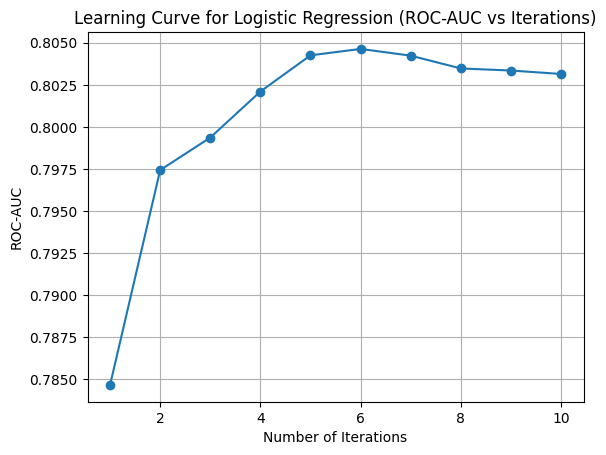

In [17]:
import matplotlib.pyplot as plt
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize the logistic regression model
log_reg = LogisticRegression(featuresCol="features_vector", labelCol="goal", maxIter=10)

# List to store the ROC-AUC values at each iteration
roc_auc_list = []

# Iterate over each iteration and evaluate performance
for i in range(1, 11):
    log_reg.setMaxIter(i)  # Set maxIter for the current iteration
    xg_model = log_reg.fit(train_data)
    predictions = xg_model.transform(test_data)
    evaluator = BinaryClassificationEvaluator(labelCol="goal", rawPredictionCol="rawPrediction")
    roc_auc = evaluator.evaluate(predictions)
    roc_auc_list.append(roc_auc)

# Plot the ROC-AUC learning curve
plt.plot(range(1, 11), roc_auc_list, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('ROC-AUC')
plt.title('Learning Curve for Logistic Regression (ROC-AUC vs Iterations)')
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator

class LearningCurve:
    def __init__(self, model, train_data, test_data, label_col="goal", features_col="features_vector", max_iter_range=None):
        self.model = model
        self.train_data = train_data
        self.test_data = test_data
        self.label_col = label_col
        self.features_col = features_col
        self.max_iter_range = max_iter_range or range(1, 21)  # Default iteration range (1 to 20)

    def evaluate_model(self, model, train_data, test_data):
        """
        Helper function to evaluate the model and return the ROC-AUC score.
        """
        model_fitted = model.fit(train_data)
        predictions = model_fitted.transform(test_data)
        evaluator = BinaryClassificationEvaluator(labelCol=self.label_col, rawPredictionCol="rawPrediction")
        roc_auc = evaluator.evaluate(predictions)
        return roc_auc

    def plot_learning_curve(self):
        """
        Plots the learning curve for the provided model.
        """
        roc_auc_list = []
        for max_iter in self.max_iter_range:
            # Set the maxIter for iterative models (like LogisticRegression)
            if hasattr(self.model, 'setMaxIter'):
                self.model.setMaxIter(max_iter)
            roc_auc = self.evaluate_model(self.model, self.train_data, self.test_data)
            roc_auc_list.append(roc_auc)

        # Plot the ROC-AUC learning curve
        plt.plot(self.max_iter_range, roc_auc_list, marker='o')
        plt.xlabel('Number of Iterations')
        plt.ylabel('ROC-AUC')
        plt.title('Learning Curve for Model (ROC-AUC vs Iterations)')
        plt.grid(True)
        plt.show()

gbt = GBTClassifier(featuresCol="features_vector", labelCol="goal", maxIter=100)
gbt_learning_curve = LearningCurve(gbt, train_data, test_data)
gbt_learning_curve.plot_learning_curve()

In [10]:
me_actual = ModelEvaluation(predictions,'goal','prediction')
me_xg = ModelEvaluation(predictions,'sb_prediction','prediction')
me_sb = ModelEvaluation(predictions,'goal','sb_prediction')

In [13]:
import pandas as pd 
m = me_actual.get_all_metrics()
sb = me_sb.get_all_metrics()
m = pd.DataFrame([m,sb], index=['created_model','statsbomb_model'])
m.transpose()

,created_model,statsbomb_model
Accuracy,0.901193,0.903167
Precision,0.722689,0.716312
Recall,0.189706,0.222794
Sensitivity,0.189706,0.222794
Specificity,0.990829,0.988884
F1,0.300524,0.339877
FPR,0.009171,0.011116
FNR,0.810294,0.777206


In [25]:
me_xg.get_all_metrics()

{'Accuracy': 0.7821472645002057,
 'Precision': 0.13488677387594356,
 'Recall': 0.9716312056737588,
 'Sensitivity': 0.9716312056737588,
 'Specificity': 0.7753153767473576,
 'F1': 0.23688760806916426,
 'FPR': 0.22468462325264235,
 'FNR': 0.028368794326241134}

In [24]:
me_sb.get_all_metrics()

{'Accuracy': 0.9031674208144796,
 'Precision': 0.7163120567375887,
 'Recall': 0.22279411764705884,
 'Sensitivity': 0.22279411764705884,
 'Specificity': 0.9888837424733673,
 'F1': 0.3398766124509255,
 'FPR': 0.0111162575266327,
 'FNR': 0.7772058823529412}

In [35]:
predictions.show(20,False)

+------------------------------------+---------+---------------+---------------+----------------+----------+-------------------+--------+-------+-------+-----------+------------+-------+-----------+-------+------+-----------+-------+-------+---------------------+----------------+-------------+------------------+------------------+------------------+--------------+---------------+---------------+---------------+--------------+--------------------+-------------------+-----------------+------------+----+-------------------------------------------------------------------+------------------------------------------+-----------------------------------------+----------+
|id                                  |player_id|shot_location_x|shot_location_y|distance_to_goal|shot_angle|preferred_foot_shot|other_pp|from_fk|from_ti|from_corner|from_counter|from_gk|from_keeper|from_ko|header|corner_type|fk_type|pk_type|half_volley_technique|volley_technique|lob_technique|overhead_technique|backheel_techniq

In [14]:
# Define a function to extract the probability of the goal (class 1)
def extract_goal_probability(probability):
    return float(probability[1])

# Register the function as a UDF
extract_goal_probability_udf = udf(extract_goal_probability, DoubleType())

# Create a new column with the goal probability
predictions_with_goal_prob = predictions.withColumn("goal_probability", extract_goal_probability_udf(col("probability")))

# Format the goal_probability to remove scientific notation
predictions_with_goal_prob = predictions_with_goal_prob.withColumn("goal_probability", format_number(col("goal_probability"), 10))

# Add a new column showing the difference between shot_statsbomb_xg and goal_probability
predictions_with_goal_prob = predictions_with_goal_prob.\
    withColumn("difference", format_number(col("shot_statsbomb_xg") - col("goal_probability"),10))

predictions_with_goal_prob = predictions_with_goal_prob.\
    withColumn("difference_abs", format_number(abs(col('difference')),10))

# Show the results
predictions_with_goal_prob.select("shot_statsbomb_xg", "goal_probability", "difference",'difference_abs').show(50,False)

+-----------------+----------------+-------------+--------------+
|shot_statsbomb_xg|goal_probability|difference   |difference_abs|
+-----------------+----------------+-------------+--------------+
|0.10166888       |0.1114529814    |-0.0097841014|0.0097841014  |
|0.026109         |0.0443075330    |-0.0181985330|0.0181985330  |
|0.064399794      |0.1162504310    |-0.0518506370|0.0518506370  |
|0.033228997      |0.0525955728    |-0.0193665758|0.0193665758  |
|0.14392917       |0.2581317831    |-0.1142026131|0.1142026131  |
|0.073996074      |0.0731947701    |0.0008013039 |0.0008013039  |
|0.7835           |0.8055580257    |-0.0220580257|0.0220580257  |
|0.10890295       |0.1164947797    |-0.0075918297|0.0075918297  |
|0.05416238       |0.0487551254    |0.0054072546 |0.0054072546  |
|0.07232883       |0.0674026946    |0.0049261354 |0.0049261354  |
|0.087863006      |0.0467176234    |0.0411453826 |0.0411453826  |
|0.121686585      |0.1491249284    |-0.0274383434|0.0274383434  |
|0.0638635

In [15]:
# average of the difference
avg_diff = predictions_with_goal_prob.select(avg(col("difference"))).collect()[0][0]
abs_avg_diff = predictions_with_goal_prob.select(avg(col("difference_abs"))).collect()[0][0]

print(f"Average difference: {avg_diff}")
print(f"Abs average difference: {abs_avg_diff}")

Average difference: -0.006297632282196625
Abs average difference: 0.03164849157705469


In [16]:
# round the goal_probability to 0 or 1, same for the shot_statsbomb_xg and compare with goal to check the accuracy of the model
# vs the accuracy of the shot_statsbomb_xg model
predictions_with_goal_prob = predictions_with_goal_prob.withColumn("goal_probability_rounded", round(col("goal_probability")))\
    .withColumn("shot_statsbomb_xg_rounded", round(col("shot_statsbomb_xg")))

# Check if the rounded probability matches the actual goal for your model
predictions_with_accuracy = predictions_with_goal_prob.withColumn(
    "model_correct", when(col("goal") == col("goal_probability_rounded"), 1).otherwise(0))\
    .withColumn("statsbomb_correct", when(col("goal") == col("shot_statsbomb_xg_rounded"), 1).otherwise(0))
# Calculate accuracy
accuracy_model = predictions_with_accuracy.selectExpr("avg(model_correct) as model_accuracy").first()["model_accuracy"]
accuracy_statsbomb = predictions_with_accuracy.selectExpr("avg(statsbomb_correct) as statsbomb_accuracy").first()["statsbomb_accuracy"]

print(f"Model Accuracy: {accuracy_model * 100:.2f}%")
print(f"StatsBomb xG Accuracy: {accuracy_statsbomb * 100:.2f}%")

Model Accuracy: 90.27%
StatsBomb xG Accuracy: 90.32%


In [17]:
# Testing matching of models, is out model as good as SB_xg?
predictions_with_accuracy = predictions_with_goal_prob.withColumn(
    "model_to_sbxg", when(col("goal_probability_rounded") == col("shot_statsbomb_xg_rounded"), 1).otherwise(0))

xg_accuracy_model = predictions_with_accuracy.selectExpr("avg(model_to_sbxg) as model_accuracy").first()["model_accuracy"]

print(f"Models matching percentage: {xg_accuracy_model * 100:.2f}%")

Models matching percentage: 98.54%


In [ ]:
# show each feature with its coefficient
coefficients = xg_model.stages[-1].coefficients
features_coefficients = list(zip(features, coefficients))

for feature, coefficient in features_coefficients:
    print(f"{feature}: {coefficient}")

In [19]:
train_predictions = xg_model.transform(train_data)
test_predictions = xg_model.transform(test_data)

In [20]:
# calculate accuracy for each model
train_accuracy = train_predictions.filter(train_predictions.goal == train_predictions.prediction).count() / train_predictions.count()

test_accuracy = test_predictions.filter(test_predictions.goal == test_predictions.prediction).count() / test_predictions.count()

print(f"Train accuracy: {train_accuracy * 100:.2f}%")
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Train accuracy: 91.05%
Test accuracy: 90.27%


In [75]:
spark.stop()